<a href="https://colab.research.google.com/github/kedar03/Mitochondria-Detection-in-Electron-microscopy-images/blob/main/Mitochondria_detection_using_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Required imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Loading Unet Tensorflow code from github

In [2]:
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-ry45ufj0
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-ry45ufj0
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25687 sha256=1c8b6bbc7a1a65bc318e6c9f674e7ece9262b3e118c0aff070eef8dcff7a6d16
  Stored in directory: /tmp/pip-ephem-wheel-cache-cik226g3/wheels/f5/38/c8/8f0a157cfd7616cc1a24811a52b9a669c0ee8fccc9f99d3cbc
Successfully built unet


Unet is now imported in notebook

In [3]:
import unet

Required Tensorflow liabraries:

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

#Data pre-processing

In [11]:
IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]

In [12]:
def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # Here we are loading the mitochondria data from mito.npz file
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        # Normalizing the image to 0..1

        image = tf.cast(image,tf.float32)/255.0
        mask -= 1 

        # Using Tensorflow to flip the image horizontally

        if tf.random.uniform(()) > 0.5:            
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        # Using Tensorflow to flip the image vertically

        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)

        # Using Tensorflow to rotate the image 90 degrees
  
        if tf.random.uniform(()) > 0.5:
            image = tf.image.rot90(image)
            mask = tf.image.rot90(mask)


        # Data augmentation done, let's store the image
        images[i] = image

        # Here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

#Training the U-net model

Train-test-validation split using load_data method.

In [14]:
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

Setting up U-net model

In [15]:
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

Setting up trainer

In [16]:
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

Training the U-net model for 50 epochs and batch size of 10

In [17]:
trainer.fit(unet_model,
            train,
            val,
            epochs = 50,
            batch_size= 10)

Epoch 1/50
47/47 [==============================] - 63s 1s/step - loss: 0.4009 - categorical_crossentropy: 0.4009 - categorical_accuracy: 0.6219 - mean_iou: 0.3175 - dice_coefficient: 0.6457 - auc: 0.8462 - val_loss: 0.4406 - val_categorical_crossentropy: 0.4406 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3020 - val_dice_coefficient: 0.6080 - val_auc: 0.9940
Epoch 2/50
47/47 [==============================] - 40s 856ms/step - loss: 0.1223 - categorical_crossentropy: 0.1223 - categorical_accuracy: 0.9114 - mean_iou: 0.4087 - dice_coefficient: 0.8412 - auc: 0.9727 - val_loss: 0.0833 - val_categorical_crossentropy: 0.0833 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.4342 - val_dice_coefficient: 0.8883 - val_auc: 0.9948
Epoch 3/50
47/47 [==============================] - 39s 839ms/step - loss: 0.1073 - categorical_crossentropy: 0.1073 - categorical_accuracy: 0.9115 - mean_iou: 0.4125 - dice_coefficient: 0.8513 - auc: 0.9705 - val_loss: 0.1419 - val_categorical_crossentropy

#Prediction using trained U-net model:

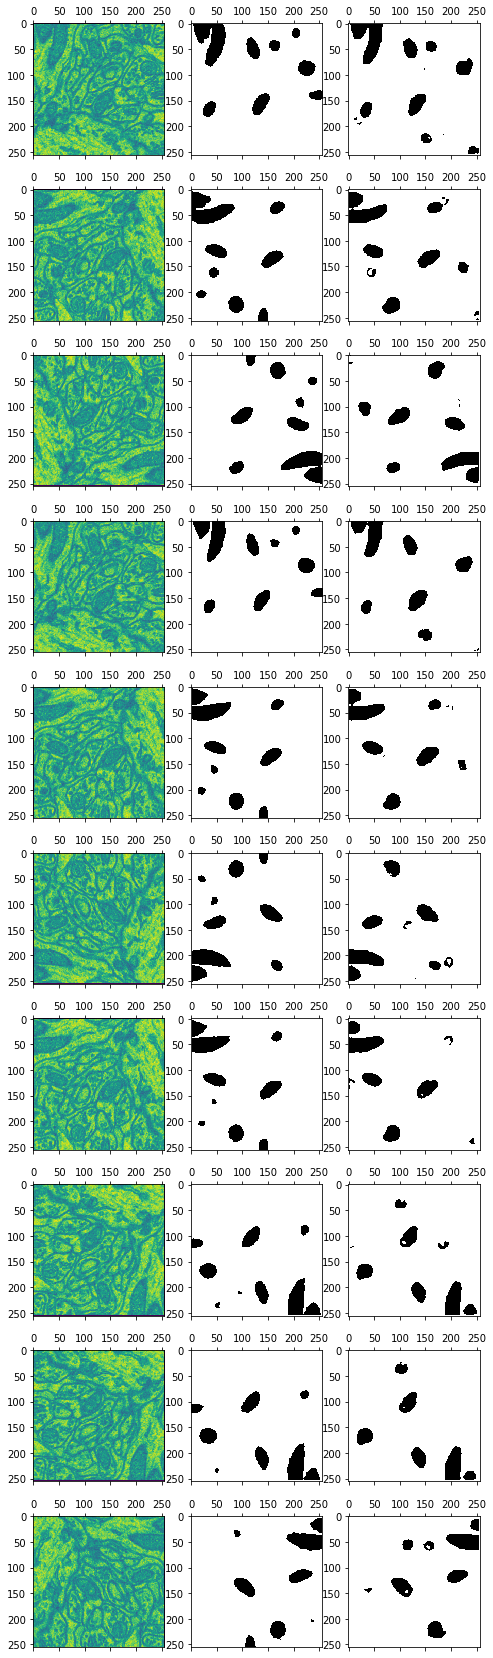

In [18]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

#From the above images we can see that U-net has performed very well for given dataset. However we can increase its accuracy by reducing noise from the images before training it. Following is the summary of our trained U-net model.

In [19]:
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, None, None, 6 37568       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv_block[0][0]                 
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        (None, None, None, 1 221440      max_pooling2d[0][0]              
_______________________________________________________________________________________________